In [1]:
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xgboost as xgb

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# String matching libs:
import pyjarowinkler
from pyjarowinkler import distance as jw
import Levenshtein
import fuzzy
from fuzzywuzzy import fuzz
import jellyfish

In [2]:
'''
df = pd.read_csv('name_election_features_20190616_1M.csv',
                 sep='\t',
                 header=None,
                 error_bad_lines=False,engine='python'
    )
'''

"\ndf = pd.read_csv('name_election_features_20190616_1M.csv',\n                 sep='\t',\n                 header=None,\n                 error_bad_lines=False,engine='python'\n    )\n"

In [3]:
%%query_hive --hiveserver prod-agatti-dp-m-2
SELECT
  t1.*
FROM data.name_election_features t1
JOIN (  -- Sampling ~100k phone numbers gives ~1M contacts
    SELECT 
      DISTINCT tin.phone_number 
    FROM(
     SELECT 
       phone_number 
     FROM data.name_election_features 
     WHERE dt='20190721' 
     AND country_code='NG'
     AND LENGTH(phone_number)>6
     AND rand(1)<0.001) tin
    LIMIT 100000
) tin2
ON t1.phone_number = tin2.phone_number
WHERE t1.dt='20190721'
LIMIT 1100000

Query took: 460.01082 seconds


,phone_number,country_code,profile_name,transliterated_profile_name,elected_name,transliterated_elected_name,candidate_name,transliterated_candidate_name,source,email_domain,...,old_ne_weight,num_contacts_provided,match_score_ugc_avg,num_contacts_with_ver_prof,match_score_profile_avg,junkiness_part0,junkiness_part1,junkiness_part2,dt,parameters
0,2347012653622,NG,king solo,king solo,churchill airtel,churchill airtel,hondai man 2,hondai man 2,phonebook,,...,0.779556,140.0,0.604363,133.0,0.535918,NaN,0.948480,0.998283,20190721,sample_0.10
1,2347012653622,NG,king solo,king solo,churchill airtel,churchill airtel,churchill iguodala,churchill iguodala,email,gmail.com,...,3.030831,NaN,NaN,NaN,NaN,0.484197,0.297338,NaN,20190721,sample_0.10
2,2347012653622,NG,king solo,king solo,churchill airtel,churchill airtel,solomon,solomon,phonebook,,...,0.354739,177.0,0.609155,170.0,0.552538,0.451223,NaN,NaN,20190721,sample_0.10
3,2347012653622,NG,king solo,king solo,churchill airtel,churchill airtel,churchill iguodala,churchill iguodala,email,gmail.com,...,3.030831,NaN,NaN,NaN,NaN,0.484197,0.297338,NaN,20190721,sample_0.10
4,2347012653622,NG,king solo,king solo,churchill airtel,churchill airtel,churchill iguodala,churchill iguodala,email,gmail.com,...,3.030831,NaN,NaN,NaN,NaN,0.484197,0.297338,NaN,20190721,sample_0.10
5,2347012653622,NG,king solo,king solo,churchill airtel,churchill airtel,churchill iguodala,churchill iguodala,email,gmail.com,...,3.030831,NaN,NaN,NaN,NaN,0.484197,0.297338,NaN,20190721,sample_0.10
6,2347012653622,NG,king solo,king solo,churchill airtel,churchill airtel,churchill iguodala,churchill iguodala,email,gmail.com,...,3.030831,141.0,0.683091,126.0,0.545143,0.484197,0.297338,NaN,20190721,sample_0.10
7,2347012653622,NG,king solo,king solo,churchill airtel,churchill airtel,my airtel line,my airtel line,phonebook,,...,2.142098,554.0,0.683820,524.0,0.588765,0.990594,0.990480,0.970502,20190721,sample_0.10
8,2347012653622,NG,king solo,king solo,churchill airtel,churchill airtel,churchil,churchil,phonebook,,...,3.234840,1557.0,0.696672,1474.0,0.596013,0.902001,NaN,NaN,20190721,sample_0.10
9,2347012653622,NG,king solo,king solo,churchill airtel,churchill airtel,churchill airtel,churchill airtel,phonebook,,...,3.424549,92.0,0.749740,83.0,0.550341,0.484197,0.990480,NaN,20190721,sample_0.10


In [4]:
df = _

In [5]:
df[['country_code', 'candidate_name','transliterated_candidate_name', 'source', 'email_domain', 'register_id',
                        'timestamp', 'str_comp', 'num_words', 'num_chars', 'age_days','old_ne_weight',
                        'num_contacts_provided', 'match_score_ugc_avg', 'num_contacts_with_ver_prof', 'match_score_profile_avg',
                        'junkiness_part0', 'junkiness_part1', 'junkiness_part2']].iloc[0]


country_code                                NG
candidate_name                    hondai man 2
transliterated_candidate_name     hondai man 2
source                               phonebook
email_domain                                  
register_id                          608866639
timestamp                        1504991011000
str_comp                               1.35023
num_words                                    3
num_chars                                   12
age_days                                   680
old_ne_weight                         0.779556
num_contacts_provided                      140
match_score_ugc_avg                   0.604363
num_contacts_with_ver_prof                 133
match_score_profile_avg               0.535918
junkiness_part0                            NaN
junkiness_part1                        0.94848
junkiness_part2                       0.998283
Name: 0, dtype: object

In [6]:
# Check for conformity with expectations:
if np.any(df.columns != [
    "phone_number","country_code","profile_name","transliterated_profile_name","elected_name","transliterated_elected_name","candidate_name","transliterated_candidate_name",
    "source","email_domain","register_id","timestamp","str_comp","num_words","num_chars","age_days","old_ne_weight",
    "num_contacts_provided","match_score_ugc_avg","num_contacts_with_ver_prof","match_score_profile_avg",
    "junkiness_part0","junkiness_part1","junkiness_part2","dt","parameters"
]):
    print("Error: Non-conforming DataFrame supplied.  It does not match the expected columns")
    

In [7]:
pd.set_option('display.max_columns', 50)
df.tail()
#pd.set_option('display.max_columns', 20)

,phone_number,country_code,profile_name,transliterated_profile_name,elected_name,transliterated_elected_name,candidate_name,transliterated_candidate_name,source,email_domain,register_id,timestamp,str_comp,num_words,num_chars,age_days,old_ne_weight,num_contacts_provided,match_score_ugc_avg,num_contacts_with_ver_prof,match_score_profile_avg,junkiness_part0,junkiness_part1,junkiness_part2,dt,parameters
375328,2349095156821,NG,jerry jayy,jerry jayy,jerry,jerry,jason,jason,phonebook,,305396562,1486565870000,14.007948,1,5,893,14.007948,139.0,0.640647,129.0,0.540006,0.404886,NaN,NaN,20190721,sample_0.10
375329,2349095156821,NG,jerry jayy,jerry jayy,jerry,jerry,jerry,jerry,phonebook,,422288140,1484678612000,51.033813,1,5,915,51.033813,176.0,0.681569,163.0,0.528493,0.649366,NaN,NaN,20190721,sample_0.10
375330,2349095156821,NG,jerry jayy,jerry jayy,jerry,jerry,jerry,jerry,phonebook,,408373068,1483370010000,51.033813,1,5,930,51.033813,225.0,0.763292,216.0,0.583115,0.649366,NaN,NaN,20190721,sample_0.10
375331,2349095156821,NG,jerry jayy,jerry jayy,jerry,jerry,jerry,jerry,phonebook,,365139080,1477498855000,51.033813,1,5,998,51.033813,140.0,0.724095,132.0,0.558800,0.649366,NaN,NaN,20190721,sample_0.10
375332,2349095156821,NG,jerry jayy,jerry jayy,jerry,jerry,jason,jason,phonebook,,753455854,1534857215000,14.007948,1,5,334,14.007948,520.0,0.704096,489.0,0.604858,0.404886,NaN,NaN,20190721,sample_0.10


In [8]:
# Preprocessing that needs to be duplicated for ML
df.dropna(subset=['profile_name','transliterated_profile_name','phone_number','candidate_name','register_id','elected_name','transliterated_elected_name'],inplace=True)

In [9]:
# We create the preprocessing pipelines for both numeric and categorical data.
numeric_features = ['str_comp',
       'num_words', 'num_chars', 'age_days', 'old_ne_weight',
       'num_contacts_provided', 'match_score_ugc_avg',
       'num_contacts_with_ver_prof', 'match_score_profile_avg',
       'junkiness_part0', 'junkiness_part1', 'junkiness_part2']
categorical_features = ['source','email_domain']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler',  StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
    #('encoder', LabelEncoder())])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

features = numeric_features + categorical_features

# Append classifier to preprocessing pipeline.
# Now we have a full prediction pipeline.
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', xgb.XGBRegressor(max_depth=7, n_estimators=500, learning_rate=0.03))])

In [10]:
# Do the string matching of UGC vs Profiles
df['candidate_jw_match'] = df.apply(lambda row: 0 if (len(row['transliterated_candidate_name'])==0 or len(row['transliterated_profile_name'])==0) else jw.get_jaro_distance(row['transliterated_candidate_name'].lower(), row['transliterated_profile_name'].lower(), winkler=True,scaling=0.1) , axis=1)

In [11]:
# And the string matching of election name vs Profiles
df['elected_jw_match'] = df.apply(lambda row: 0 if (len(row['transliterated_elected_name'])==0 or len(row['transliterated_profile_name'])==0) else jw.get_jaro_distance(row['transliterated_elected_name'].lower(), row['transliterated_profile_name'].lower(), winkler=True,scaling=0.1) , axis=1)

In [12]:
# Map df of all possible contacts into list of single best possible contacts (best possible score)
def elect_best_case(df):
    # Get the indices for the best possible match
    idx = df.groupby(['phone_number'])['candidate_jw_match'].transform(max) == df['candidate_jw_match']
    dfb = df[idx].drop_duplicates(subset=['phone_number','candidate_jw_match'])
    dfb.sort_values('phone_number',inplace=True)
    return dfb

dfb = elect_best_case(df)

In [13]:
# Do test/train split, which takes special care since data about a single phone number can be
# spread over multiple rows.  So Sample phone numbers (not rows in df)
unique_nums = pd.Series(pd.unique(df['phone_number']))
nums_train = unique_nums.sample(frac=0.8,random_state=200)
#nums_test  = unique_nums.drop(nums_train.index)

In [14]:
df_train = df[ df['phone_number'].isin(nums_train)]
df_test  = df[~df['phone_number'].isin(nums_train)]

In [15]:
print('total:',len(df))
print('train:',len(df_train))
print('test: ',len(df_test))

total: 375333
train: 300618
test:  74715


In [16]:
# Keep these as DataFrames so we can use column names
X_train = df_train[features]
X_test  = df_test [features]

In [17]:
#Y_train = df_train['candidate_jw_match']

# Boxy scoring function to ignore poor matches and count perfect matches as double.
def score_calc(val):
    #return val
    # Try boxy scoring to up-weight perfect matches
    if   val<0.80:  return 0
    elif val>=0.98: return 1.0
    else:           return 0.5
    
Y_train = df_train['candidate_jw_match'].apply(score_calc)


In [18]:
model.fit(X_train, Y_train)

Pipeline(memory=None,
         steps=[('preprocessor',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[('num',
                                                  Pipeline(memory=None,
                                                           steps=[('imputer',
                                                                   SimpleImputer(add_indicator=False,
                                                                                 copy=True,
                                                                                 fill_value=None,
                                                                                 missing_values=nan,
                                                                                 strategy='median',
                                                             

In [19]:
# Save the model by serializing with Pickle for loading into Samaritan:
import pickle
#import dill as pickle
with open("neml_model_NG_20190719_temp.pkl",'wb') as mfile:
    pickle.dump(model,mfile)

In [20]:


# At this point the model is trained and saved.  Below is for more diagnostics.



In [21]:
# Provide a score for each row.  The function `elect_ml` below will pick the highest
# row for each phone_number, thus electing the best name for the model.  
df_test['score'] = model.predict(X_test)

/home/jovyan/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [22]:
# Map df of all possible contacts into list of single best possible contacts (highest score from ML)
def elect_ml(df):
    # Get the indices for the best possible match
    idx = df.groupby(['phone_number'])['score'].transform(max) == df['score']
    dfm = df[idx].drop_duplicates(subset=['phone_number','score'])
    dfm.sort_values('phone_number',inplace=True)
    return dfm

dfm_test = elect_ml(df_test)
dfb_test = elect_best_case(df_test)

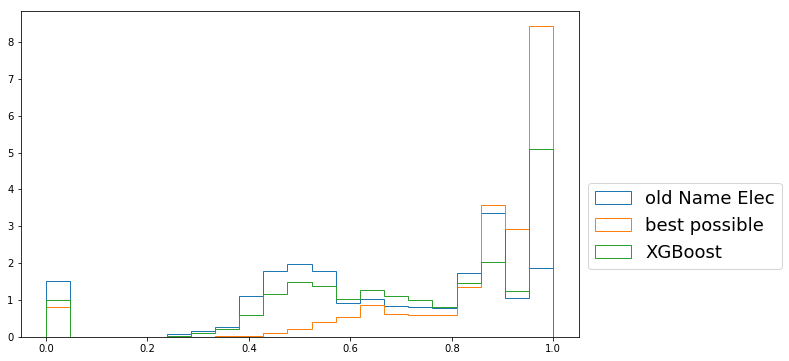

In [23]:
# Visualize the current results
plt.figure(figsize=(10,6))
plt.hist(dfb_test['elected_jw_match'],  bins=21,density=True,histtype='step',label='old Name Elec')
plt.hist(dfb_test['candidate_jw_match'],bins=21,density=True,histtype='step',label='best possible')
plt.hist(dfm_test['candidate_jw_match'],bins=21,density=True,histtype='step',label='XGBoost')
plt.legend(loc='best',prop={"size": 18},bbox_to_anchor=(1, 0.5))
plt.show()

In [24]:
# Summary of Current Name Election job, Model results, and comparison to the best possible:
# And the final contest score metric is calculated as the average JW string match of results to profile names.
def report_summary():
    p1 = (dfm_test['elected_jw_match']>=0.98).sum()/len(dfm_test)*100.
    p2 = (dfm_test['elected_jw_match']>=0.85).sum()/len(dfm_test)*100.
    p3 = (dfm_test['elected_jw_match']==0.  ).sum()/len(dfm_test)*100.
    p4 = dfm_test['elected_jw_match'].mean()
    print("Old Name Elec: \n\t% perfect:  {:0.2f}\n\t% good:     {:0.2f}\n\t% miss:     {:0.2f}\n\tMean match: {:0.2f}".format(p1,p2,p3,p4))
    print()
    p1 = (dfm_test['candidate_jw_match']>=0.98).sum()/len(dfm_test)*100.
    p2 = (dfm_test['candidate_jw_match']>=0.85).sum()/len(dfm_test)*100.
    p3 = (dfm_test['candidate_jw_match']==0.  ).sum()/len(dfm_test)*100.
    p4 = dfm_test['candidate_jw_match'].mean()
    print("ML Name Elec:  \n\t% perfect:  {:0.2f}\n\t% good:     {:0.2f}\n\t% miss:     {:0.2f}\n\tMean match: {:0.2f}".format(p1,p2,p3,p4))
    print()
    p1 = (dfb_test['candidate_jw_match']>=0.98).sum()/len(dfm_test)*100.
    p2 = (dfb_test['candidate_jw_match']>=0.85).sum()/len(dfm_test)*100.
    p3 = (dfb_test['candidate_jw_match']==0.  ).sum()/len(dfm_test)*100.
    p4 = dfb_test['candidate_jw_match'].mean()
    print("Best Possible:  \n\t% perfect:  {:0.2f}\n\t% good:     {:0.2f}\n\t% miss:     {:0.2f}\n\tMean match: {:0.2f}".format(p1,p2,p3,p4))

report_summary()

Old Name Elec: 
	% perfect:  8.22
	% good:     31.61
	% miss:     7.25
	Mean match: 0.65

ML Name Elec:  
	% perfect:  22.92
	% good:     41.35
	% miss:     4.81
	Mean match: 0.72

Best Possible:  
	% perfect:  37.70
	% good:     73.31
	% miss:     3.84
	Mean match: 0.86


Benchmark case for 'IN':
Old Name Elec: 
	% perfect:  9.03
	% good:     39.95
	% miss:     7.53
	Mean match: 0.67

ML Name Elec:  
	% perfect:  24.31
	% good:     47.97
	% miss:     4.89
	Mean match: 0.74

Best Possible:  
	% perfect:  35.99
	% good:     69.46
	% miss:     3.05
	Mean match: 0.84

In [25]:
# What are some examples where the ML model is very good and better than the old Name Election result
cut = (dfm_test['candidate_jw_match']>dfm_test['elected_jw_match']+0.2) & (dfm_test['candidate_jw_match']>=0.85)
dfm_test[cut][['profile_name','elected_name','candidate_name','elected_jw_match','candidate_jw_match']].head(50)

,profile_name,elected_name,candidate_name,elected_jw_match,candidate_jw_match
326930,bassey douglas,douglass,bassey douglas,0.53,1.00
137913,alfred moses,k c boy,alfred moses,0.48,1.00
187536,taiwo adedara,lbdr taiwo,taiwo,0.60,0.88
151538,ibrahim adimbo,khalifa adimbo,ibrahim adimbo,0.71,1.00
109936,salami jimoh,jimoh,salami jimoh,0.43,1.00
43058,duyilemi tosin,tosin,duyilemi tosinayo,0.42,0.96
50897,shoyoye tosin,tosin®,shoyoyetosin,0.44,0.98
246725,gabriel smart smart,usman,gabriel smart,0.42,0.94
340954,millah regina,regina milla,millah regina,0.54,1.00
327178,ologun temi tope,tope ologun,ologun temitope,0.62,0.99


In [26]:
# What are some examples where the ML model completely misses but the old Name Election result was okay
cut = (dfm_test['candidate_jw_match']+0.2<=dfm_test['elected_jw_match']) & (dfm_test['elected_jw_match']>=0.85)
dfm_test[cut][['profile_name','elected_name','candidate_name','elected_jw_match','candidate_jw_match','score']].head(50)

,profile_name,elected_name,candidate_name,elected_jw_match,candidate_jw_match,score
346900,progress gundiri,progress,smally progress,0.90,0.57,0.237498
201889,gift mac-afebo,gift mac-afebo,afebo gift,1.00,0.50,0.352392
304516,chetachukwu paschal,cheta,paschal chetabobo,0.85,0.60,0.408921
209787,reuben oyibo,reuben oyibo,oyibo reuben,1.00,0.69,0.463431
354669,ogbonnaya cynthia,ogbonnaya cynthia udochukwu,precious girl,0.93,0.47,0.423268
65901,remi blessing,remi,abioro remilekun,0.86,0.60,0.473602
341134,ontop nebeolisa,ontop,chigozie anthony,0.87,0.49,0.397912
297305,obaro moses,obaro,ogbijah obaro,0.89,0.65,0.492839
282808,udo okeite,udo okeite,okite udochukw,1.00,0.64,0.316834
110449,shola bunmi,shola,adeko shola,0.89,0.40,0.266917
